# Module Text Analytics: Proof of Perfomance
### Winterthur, 17.01.2023
<p>
<h2>Title: Sentiment Analysis on Twitter for Bitcoin Trading</h2>
</p>
<P><h4>Professor: </h4>
Don Tuggener
</p>
<p><h4>Students: </h4>
Sven Goldinger </br>
Furio Valerio Sordini
</p>


# 1 Data Preparation

In [ ]:
import re

import nltk
import numpy as np
import pandas as pd
import umap
from gensim.models import word2vec
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline

In [ ]:
# Text pre-processing
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('europarl_raw')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\furio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\furio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\furio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package europarl_raw to
[nltk_data]     C:\Users\furio\AppData\Roaming\nltk_data...
[nltk_data]   Package europarl_raw is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\furio\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\furio\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-dat

In [ ]:
from sklearn.model_selection import train_test_split
rs = 7 # random state

In [ ]:
# To run a TF-IDF + LogReg baseline on the data
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## 1.1 Load Dataset
The dataset is collected from kaggle (https://www.kaggle.com/datasets/gautamchettiar/bitcoin-sentiment-analysis-twitter-data)


In [ ]:
twi_path = r"bitcoin_tweets1000000.csv"
df = pd.read_csv(twi_path)
df.head()

c:\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3139: DtypeWarning: Columns (0,5,6,7,8,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,cleanText,Polarity Score,sentiment
0,0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,blue ridge bank shares halted nyse bitcoin atm...,0.00,0.0
1,1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,today thursday take friend leowandersleb btc w...,0.00,0.0
2,2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,guys evening read article btc would like share,0.00,0.0
3,3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,btc big chance billion price bitcoin btc crypto,0.00,0.0
4,4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,network secured nodes today soon biggest bears...,-0.25,0.0


In [ ]:
df.describe()

,user_followers,Polarity Score,sentiment
count,9.999970e+05,999988.000000,999986.000000
mean,9.241252e+03,0.144692,0.472943
std,1.175851e+05,0.271044,0.499268
min,0.000000e+00,-1.000000,0.000000
25%,4.500000e+01,0.000000,0.000000
50%,2.360000e+02,0.000000,0.000000
75%,1.509000e+03,0.286508,1.000000
max,2.359728e+07,1.000000,1.000000


In [ ]:
df.shape

(1000025, 17)

In [ ]:
df.dtypes

Unnamed: 0                  object
user_name                   object
user_location               object
user_description            object
user_created                object
user_followers             float64
user_friends                object
user_favourites             object
user_verified               object
date                datetime64[ns]
text                        object
hashtags                    object
source                      object
is_retweet                  object
cleanText                   object
Polarity Score             float64
sentiment                  float64
dtype: object

In [ ]:
df.user_name = df.user_name.apply(str)
df.user_location = df.user_location.apply(str)
df.user_description = df.user_description.apply(str)
df.user_created = pd.to_datetime(df.user_created, format="%Y-%m-%d %H:%M:%S", errors='coerce')
df.user_followers = pd.to_numeric(df.user_followers, errors='coerce')
df.user_friends = pd.to_numeric(df.user_friends, errors='coerce')
df.user_favourites = pd.to_numeric(df.user_favourites, errors='coerce')
df.date = pd.to_datetime(df.date, format="%Y-%m-%d %H:%M:%S", errors='coerce')
df.text = df.text.apply(str)
df.source = df.source.apply(str)
df.cleanText = df.cleanText.apply(str)
df.dtypes

Unnamed: 0                  object
user_name                   object
user_location               object
user_description            object
user_created        datetime64[ns]
user_followers             float64
user_friends               float64
user_favourites            float64
user_verified               object
date                datetime64[ns]
text                        object
hashtags                    object
source                      object
is_retweet                  object
cleanText                   object
Polarity Score             float64
sentiment                  float64
dtype: object

In [ ]:
print("Invalid Values for User Followers: {} / {}".format(df.user_followers.isna().sum(), df.shape[0]))
print("Invalid Values for User Friends: {} / {}".format(df.user_friends.isna().sum(), df.shape[0]))
print("Invalid Values for User Friends: {} / {}".format(df.user_favourites.isna().sum(), df.shape[0]))

Invalid Values for User Followers: 28 / 1000025
Invalid Values for User Friends: 33 / 1000025
Invalid Values for User Friends: 35 / 1000025


Starting and ending periods for the tweets

In [ ]:
print("Starting Period: {}".format(df.date.min()))
print("End Period: {}".format(df.date.max()))

Starting Period: 2021-02-05 10:52:04
End Period: 2021-08-21 12:58:29


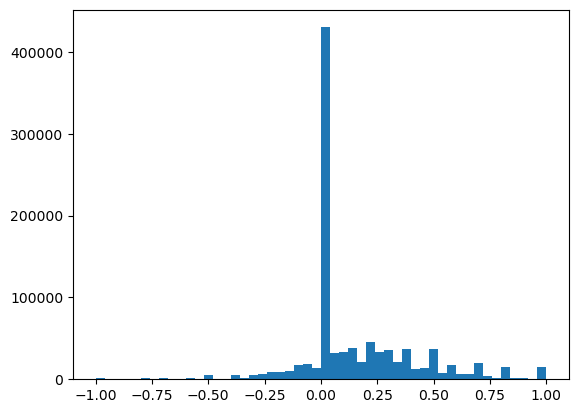

In [ ]:
plt.hist(df['Polarity Score'], bins = 50);

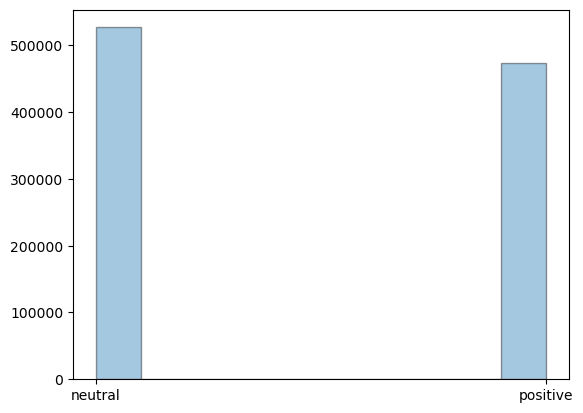

In [ ]:
plt.hist(["positive" if z == 1 else "neutral" for z in df['sentiment']], alpha = 0.4, density=False, ec='black'); #

In [ ]:
print("Percentage of tweets with positive sentiment: {}%".format(np.round(df['sentiment'].sum()/df.shape[0],4)*100))

Percentage of tweets with positive sentiment: 47.29%


The sentiment classification is balanced. From the tweets we interpret the following values:</br>
1 = positive</br>
0 = neutral or negative

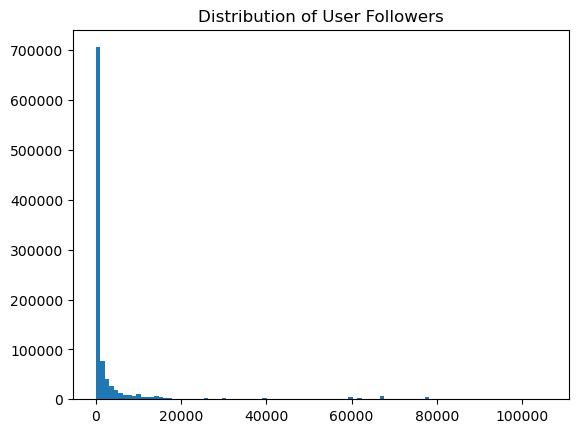

In [ ]:
p = plt.hist(df.user_followers[df.user_followers < df.user_followers.quantile(0.99)], bins= 100)
plt.ticklabel_format(axis='both', style='plain', scilimits=None, useOffset=None, useLocale=None, useMathText=None)
plt.title("Distribution of User Followers");

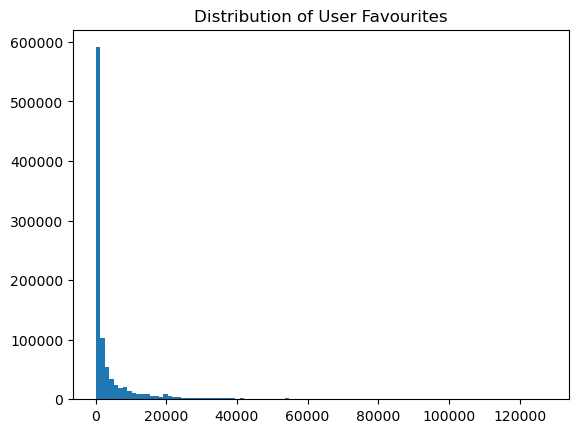

In [ ]:
plt.hist(df.user_favourites[df.user_favourites < df.user_favourites.quantile(0.99)], bins= 100)
plt.title("Distribution of User Favourites");

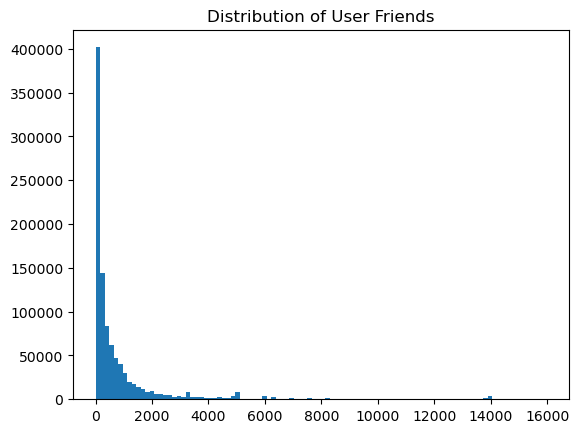

In [ ]:
plt.hist(df.user_friends[df.user_friends < df.user_friends.quantile(0.99)], bins= 100)
plt.title("Distribution of User Friends");

## 1.2 Data Cleaning
<b> REALLY NEEDED HERE?</b>
--> Unfortunately yes... or we can just keep the column "cleanText"..


In [ ]:
df.text[1]

'😎 Today, that\'s this #Thursday, we will do a "🎬 Take 2" with our friend @LeoWandersleb, #Btc #wallet #security expe… https://t.co/go6aDgRml5'

In [ ]:
df.cleanText[1]

'today thursday take friend leowandersleb btc wallet security expe'

## 1.3 Train and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
rs = 7 # random state
X_train, X_test, y_train, y_test = train_test_split(df['cleanText'], df['sentiment'], test_size=0.15, random_state=rs, shuffle=True)

# 2 Text Classification

## 2.1 Baseline Method: Logistic Regression

In [ ]:
# Run a TF-IDF + LogReg baseline on the data
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# TFIDF Vectorization
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(X_train.tolist())
test_features = vectorizer.transform(X_test.tolist())
train_labels, test_labels = ["positive" if y == 1 else "neutral" for y in y_train], ["positive" if y == 1 else "neutral" for y in y_test]

# Classifier training
classifier = LogisticRegression(C=1, max_iter=10000, class_weight=None)
classifier.fit(train_features, train_labels)

predicted_labels_tf_log_reg = classifier.predict(test_features)
print(classification_report(test_labels, predicted_labels_tf_log_reg))

              precision    recall  f1-score   support

     neutral       0.98      0.98      0.98     79184
    positive       0.98      0.97      0.98     70820

    accuracy                           0.98    150004
   macro avg       0.98      0.98      0.98    150004
weighted avg       0.98      0.98      0.98    150004



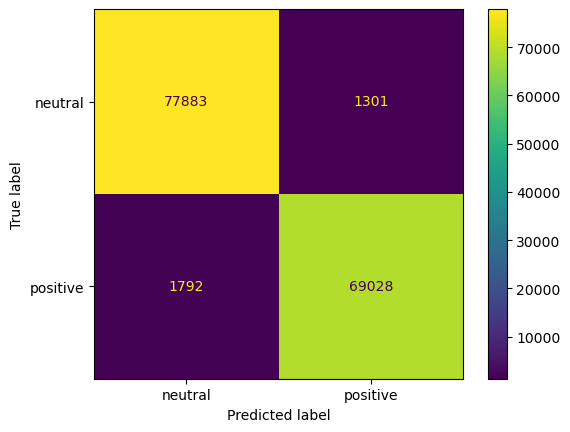

In [ ]:
cm_log_reg = confusion_matrix(test_labels, predicted_labels_tf_log_reg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=classifier.classes_)
disp.plot();

# CONSIDERATION: 
the labels are produced with a machine learning technique. Building a classifier on syntetic data does not make sense. A new dataset with human labelled data is considered

# 3 Data Preparation
The new dataset is also loaded from kaggle (https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis).
The dataset has 5322 rows and 2 columns (sentence and sentiment)

In [ ]:
human_labels_path = r"data.csv"
hl = pd.read_csv(human_labels_path)
hl.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
hl.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,The maritime administration said the ships had...,neutral
freq,2,3130


In [ ]:
hl.dtypes

Sentence     object
Sentiment    object
dtype: object

In [ ]:
hl.shape

(5842, 2)

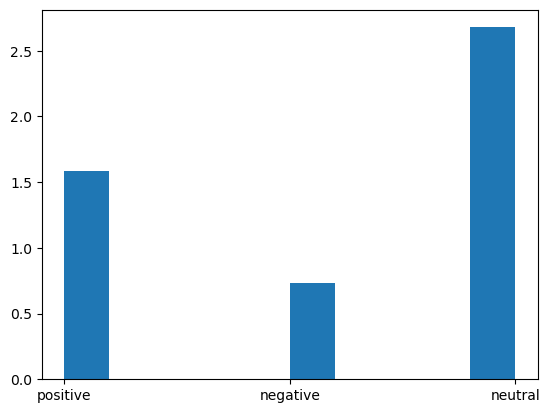

In [ ]:
plt.hist(hl.Sentiment, density=True);

## 3.2 Data Cleaning

### 3.2.1 Lemmatization

In [ ]:
wnl = WordNetLemmatizer()

In [ ]:
def wordnet_lemmatize_text(text):
  # tokenize text
  tokens = nltk.word_tokenize(text)
  # pos tag tokenized text
  tagged_tokens = nltk.pos_tag(tokens)
  # convert raw POS tags into wordnet tags
  tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
  # treat unknown tags as nouns by default
  new_tagged_tokens = [(word, tag_map.get(tag[0].lower(), 
                                          wordnet.NOUN))
                            for word, tag in tagged_tokens]

  lemmatized_text = ' '.join(wnl.lemmatize(word, tag) for word, tag in new_tagged_tokens)
  return lemmatized_text

In [ ]:
hl['Sent_Lemm'] = hl.Sentence.apply(lambda x: wordnet_lemmatize_text(x))
hl['Sent_Lemm']

0       The GeoSolutions technology will leverage Bene...
1       $ ESI on low , down $ 1.50 to $ 2.50 BK a real...
2       For the last quarter of 2010 , Componenta 's n...
3       According to the Finnish-Russian Chamber of Co...
4       The Swedish buyout firm have sell it remain 22...
                              ...                        
5837    RISING cost have force packaging producer Huht...
5838    Nordic Walking be first use a a summer trainin...
5839    According ship company Viking Line , the EU de...
5840    In the building and home improvement trade , s...
5841    HELSINKI AFX - KCI Konecranes say it have win ...
Name: Sent_Lemm, Length: 5842, dtype: object

### 3.2.2 Stop Word Removal

In [ ]:
def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [ ]:
hl['Stop_Words'] = hl.Sent_Lemm.apply(lambda x: remove_stopwords(x))
hl['Stop_Words']

0       GeoSolutions technology leverage Benefon 's GP...
1           $ ESI low , $ 1.50 $ 2.50 BK real possibility
2       last quarter 2010 , Componenta 's net sale dou...
3       According Finnish-Russian Chamber Commerce , m...
4       Swedish buyout firm sell remain 22.4 percent s...
                              ...                        
5837    RISING cost force packaging producer Huhtamaki...
5838    Nordic Walking first use summer training metho...
5839    According ship company Viking Line , EU decisi...
5840    building home improvement trade , sale decreas...
5841    HELSINKI AFX - KCI Konecranes say win order fo...
Name: Stop_Words, Length: 5842, dtype: object

### 3.2.3 Removing Special Characters

In [ ]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [ ]:
hl['CleanSentence'] = hl.Stop_Words.apply(lambda x: remove_special_characters(x))
hl['CleanSentence']

0       GeoSolutions technology leverage Benefon s GPS...
1                  ESI low   150  250 BK real possibility
2       last quarter 2010  Componenta s net sale doubl...
3       According FinnishRussian Chamber Commerce  maj...
4       Swedish buyout firm sell remain 224 percent st...
                              ...                        
5837    RISING cost force packaging producer Huhtamaki...
5838    Nordic Walking first use summer training metho...
5839    According ship company Viking Line  EU decisio...
5840    building home improvement trade  sale decrease...
5841    HELSINKI AFX  KCI Konecranes say win order fou...
Name: CleanSentence, Length: 5842, dtype: object

## 3.3 Test / Train Split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(hl['CleanSentence'], hl['Sentiment'], test_size=0.15, random_state=rs, shuffle=True)

# 4 Text Classification

## 4.1 Baseline Model

In [ ]:
# TFIDF Vectorization
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(X_train.tolist())
test_features = vectorizer.transform(X_test.tolist())

# Classifier training
classifier = LogisticRegression(C=1, max_iter=10000, class_weight=None)
classifier.fit(train_features, y_train)

predicted_labels_tf_log_reg = classifier.predict(test_features)
print(classification_report(y_test, predicted_labels_tf_log_reg))

              precision    recall  f1-score   support

    negative       0.41      0.16      0.23       138
     neutral       0.70      0.86      0.77       476
    positive       0.71      0.65      0.68       263

    accuracy                           0.69       877
   macro avg       0.61      0.56      0.56       877
weighted avg       0.66      0.69      0.66       877



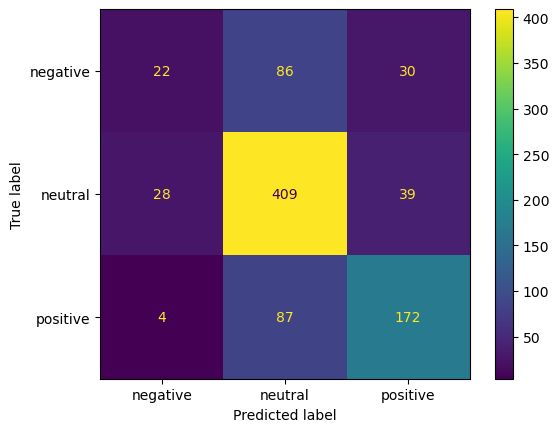

In [ ]:
cm_logistic = confusion_matrix(y_test, predicted_labels_tf_log_reg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=classifier.classes_)
disp.plot();

## 4.2 Vader
Vader is a lexicon and rule based pre-trained sentiment analysis tool, tuned for social media. 
Vader represents the part of text that can be classified as positive, neutral and negative and returns as well a compound score (as the sum of the lexicon ratings)

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\furio\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

sentence = "The phone is cool, but very expensive!"
score = analyser.polarity_scores(sentence)

print("{:-<40} {}".format(sentence, str(score)))

The phone is cool, but very expensive!-- {'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'compound': 0.2363}


In [ ]:
feature_col = 'Sentence'
df_snt_vader = hl[feature_col].apply(lambda row: analyser.polarity_scores(row))

hl['neg'] = [score["neg"] for score in df_snt_vader.values]
hl['neu'] = [score["neu"] for score in df_snt_vader.values]
hl['pos'] = [score["pos"] for score in df_snt_vader.values]
hl['compound'] = [score["compound"] for score in df_snt_vader.values]

In [ ]:
hl.head()

,Sentence,Sentiment,Sent_Lemm,Stop_Words,CleanSentence,neg,neu,pos,compound
0,The GeoSolutions technology will leverage Bene...,positive,The GeoSolutions technology will leverage Bene...,GeoSolutions technology leverage Benefon 's GP...,GeoSolutions technology leverage Benefon s GPS...,0.000,0.847,0.153,0.5423
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"$ ESI on low , down $ 1.50 to $ 2.50 BK a real...","$ ESI low , $ 1.50 $ 2.50 BK real possibility",ESI low 150 250 BK real possibility,0.167,0.833,0.000,-0.2023
2,"For the last quarter of 2010 , Componenta 's n...",positive,"For the last quarter of 2010 , Componenta 's n...","last quarter 2010 , Componenta 's net sale dou...",last quarter 2010 Componenta s net sale doubl...,0.064,0.856,0.080,0.1531
3,According to the Finnish-Russian Chamber of Co...,neutral,According to the Finnish-Russian Chamber of Co...,"According Finnish-Russian Chamber Commerce , m...",According FinnishRussian Chamber Commerce maj...,0.000,1.000,0.000,0.0000
4,The Swedish buyout firm has sold its remaining...,neutral,The Swedish buyout firm have sell it remain 22...,Swedish buyout firm sell remain 22.4 percent s...,Swedish buyout firm sell remain 224 percent st...,0.000,1.000,0.000,0.0000


turning the vader values in labels

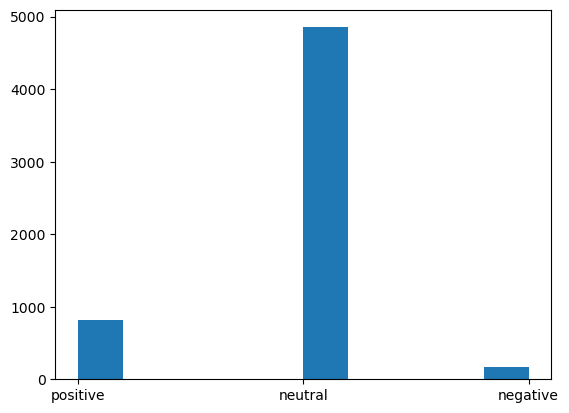

In [ ]:
threshold = 0.5

def VaderToLabel(compound_score):
    # labels = []
    #for i in compound_scores:
    if compound_score > threshold:
     return 'positive' 
    if compound_score < -threshold:
        return 'negative'
    if (compound_score <=threshold) and (compound_score >= -threshold):
        return 'neutral'

hl['Vader'] = hl.compound.apply(lambda x: VaderToLabel(x))

hl.Vader.hist(grid=False);

In [ ]:
print(classification_report(hl.Sentiment, hl.Vader))

              precision    recall  f1-score   support

    negative       0.49      0.10      0.16       860
     neutral       0.57      0.89      0.70      3130
    positive       0.58      0.26      0.36      1852

    accuracy                           0.57      5842
   macro avg       0.55      0.41      0.40      5842
weighted avg       0.56      0.57      0.51      5842



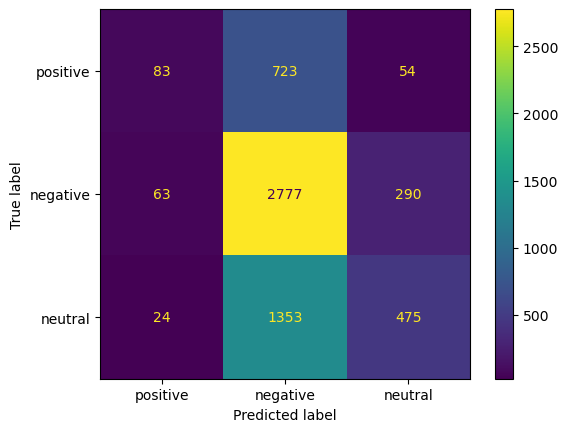

In [ ]:
cm_vader = confusion_matrix(hl.Sentiment, hl.Vader)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vader, display_labels=hl.Sentiment.unique())
disp.plot();

## 4.3 Method 2: LSTM based on Word2Vec

In [ ]:
from nptyping import NDArray
import json
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Download the embeddings and vocab file here: https://drive.switch.ch/index.php/s/rNmy0yKDDkRAmcq
word_embeddings = np.load('wiki.multi.en.vec_data.npy')
vocab = json.load(open('wiki.multi.en.vec_vocab.json'))

In [ ]:
def tokenize(texts: list[str]) -> list[list[str]]:
    return [re.findall(r'\w+', text.lower()) for text in texts]

In [ ]:
train_tokens = tokenize(X_train.tolist())
ohe = OneHotEncoder(sparse=False)  # One-hot encode string labels
train_labels = ohe.fit_transform([[label] for label in y_train.tolist()])
test_labels = ohe.fit_transform([[label] for label in y_test.tolist()])

In [ ]:
# Only use needed word embeddings, do this to save RAM
# Build vocab on training data
train_vocab = {'PAD': 0}  # special padding symbol
selected_word_embeddings = [np.zeros(word_embeddings.shape[1])]  # zero vector for PAD symbol
for tokens in train_tokens:
    for token in tokens:
        if not token in train_vocab:
            if token in vocab:
                train_vocab[token] = max(train_vocab.values()) + 1
                selected_word_embeddings.append(word_embeddings[vocab[token]])

selected_word_embeddings = np.array(selected_word_embeddings)
del word_embeddings

In [ ]:
def tok2int(tokens_list: list, vocab: dict) -> list[list[int]]:
    """Replaces tokens with their assigned IDs"""
    token_ints = list()
    for tokens in tokens_list:
        token_ints.append([vocab[tok] for tok in tokens if tok in vocab])
    return token_ints

In [ ]:
maxlen = max(len(tokens) for tokens in train_tokens)
train_ints = tok2int(train_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
train_ints_padded = tf.keras.utils.pad_sequences(train_ints, maxlen=maxlen)

In [ ]:
# Define the model: Try changing the layers and their sizes
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(train_vocab), # Number of tokens in the dicitonary
                                    mask_zero=True,  # ignore padding symbol
                                    input_length=maxlen,  # max text length
                                    embeddings_initializer=tf.keras.initializers.Constant(selected_word_embeddings),  # initialize the embeddings with the pretrained ones
                                    trainable=False,  # we're not updating the pre-trained word embeddings
                                    output_dim=300)  # dimensions of the word embeddings
         )
# model.add(tf.keras.layers.GlobalAveragePooling1D())  # Average the word embeddings
model.add(tf.keras.layers.LSTM(128))  # LSTM instead of average pooling
model.add(tf.keras.layers.Dense(512, activation='relu'))  # "Hidden" layer
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))  # Final classification layer
model.compile(optimizer='adam', loss='CategoricalCrossentropy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 300)           1945200   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 2,232,435
Trainable params: 287,235
Non-trainable params: 1,945,200
_________________________________________________________________
None


In [ ]:
# Train
model.fit(train_ints_padded, train_labels, epochs=20, verbose=1, validation_split=0.1, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ])

Epoch 1/20
140/140 [==============================] - 52s 233ms/step - loss: 0.9132 - val_loss: 0.7579
Epoch 2/20
140/140 [==============================] - 25s 181ms/step - loss: 0.7727 - val_loss: 0.6923
Epoch 3/20
140/140 [==============================] - 25s 180ms/step - loss: 0.6845 - val_loss: 0.6434
Epoch 4/20
140/140 [==============================] - 31s 221ms/step - loss: 0.6342 - val_loss: 0.6291
Epoch 5/20
140/140 [==============================] - 25s 176ms/step - loss: 0.6037 - val_loss: 0.6373
Epoch 6/20
140/140 [==============================] - 27s 192ms/step - loss: 0.5535 - val_loss: 0.6483
Epoch 7/20
140/140 [==============================] - 26s 187ms/step - loss: 0.5248 - val_loss: 0.6766


In [ ]:
# Predict & Evaluate
test_tokens = tokenize(X_test.tolist())
test_ints = tok2int(test_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
test_ints_padded = tf.keras.utils.pad_sequences(test_ints, maxlen=maxlen)

In [ ]:
predicted_labels_pretrained_int = model.predict(test_ints_padded)

28/28 [==============================] - 9s 76ms/step


In [ ]:
predicted_labels_pretrained = ohe.inverse_transform(predicted_labels_pretrained_int)  # Map predicted scores back to labels
predicted_labels_pretrained = [labels[0] for labels in predicted_labels_pretrained]
print(classification_report(y_test, predicted_labels_pretrained))

              precision    recall  f1-score   support

    negative       0.42      0.49      0.45       138
     neutral       0.78      0.79      0.78       476
    positive       0.72      0.66      0.69       263

    accuracy                           0.70       877
   macro avg       0.64      0.64      0.64       877
weighted avg       0.71      0.70      0.70       877



## 4.4 Word-Embeddings (learned from scratch)

In [ ]:
rs = 7 # random state
X_train, X_test, y_train, y_test = train_test_split(df['cleanText'], df['sentiment'], test_size=0.15, random_state=rs, shuffle=True)

In [ ]:
def tokenize(texts):
    return [re.findall(r'\w+', text.lower()) for text in texts]

In [ ]:
y_train = y_train.replace(np.nan, 0)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
word_embeddings = np.load('drive/MyDrive/TextAnalytics/Lab4/fastText_MUSE/wiki.multi.en.vec_data.npy')
vocab = json.load(open('drive/MyDrive/TextAnalytics/Lab4/fastText_MUSE/wiki.multi.en.vec_vocab.json'))

In [ ]:
train_tokens = tokenize(X_train.tolist())
train_labels = y_train.to_numpy()

In [ ]:
train_vocab = {'PAD': 0} 

for tokens in train_tokens:
    for token in tokens:
        if not token in train_vocab:
            train_vocab[token] = max(train_vocab.values()) + 1            

def tok2int(tokens_list: list, vocab: dict):
    """Replaces tokens with their assigned IDs"""
    token_ints = list()
    for tokens in tokens_list:
        token_ints.append([vocab[tok] for tok in tokens if tok in vocab])
    return token_ints

maxlen = max(len(tokens) for tokens in train_tokens)
train_ints = tok2int(train_tokens, train_vocab)
train_ints_padded = tf.keras.utils.pad_sequences(train_ints, maxlen=maxlen)


In [ ]:
# Define the model: Try changing the layers and their sizes
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(train_vocab), # Number of tokens in the dicitonary
                                    mask_zero=True,  # ignore padding symbol
                                    input_length=maxlen,  # max text length                                    
                                    trainable=False,  # we're not updating the pre-trained word embeddings
                                    output_dim=300)  # dimensions of the word embeddings
         )
model.add(tf.keras.layers.GlobalAveragePooling1D())  # Average the word embeddings
model.add(tf.keras.layers.Dense(512, activation='relu'))  # "Hidden" layer
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Final classification layer
model.compile(optimizer='adam', loss='BinaryCrossentropy')
print(model.summary())

In [ ]:
# Train
model.fit(train_ints_padded, train_labels, epochs=10, verbose=1, validation_split=0.1, 
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
          )

In [ ]:
# Predict & Evaluate
test_tokens = tokenize(X_test.tolist())
test_ints = tok2int(test_tokens, train_vocab)

In [ ]:
# Make all texts the same length, pad with zeroes
test_ints_padded = tf.keras.utils.pad_sequences(test_ints, maxlen=maxlen)
predicted_labels_pretrained_int = model.predict(test_ints_padded)

In [ ]:
y_test = y_test.replace(np.nan, 0)
y_test_list = y_test.tolist()
predicted_label_list = []
for it in predicted_labels_pretrained_int:
  predicted_label_list.append(round(it[0]))

In [ ]:
print(classification_report(y_test_list, predicted_label_list)) #predicted_labels_pretrained

# 5. Bitcoin prices vs. Tweet Sentiment

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np

data = pd.read_csv('drive/MyDrive/_Leistungsnachweis/btc_historical_price.csv')

In [ ]:
def NormalizeData(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

##Data preparation
###Select bitcoin prices for 2021

In [ ]:
data = data[(data.date >= '2021-01-01') & (data.date <= '2021-12-31')]
data.date = pd.to_datetime(data.date, format="%Y-%m-%d", errors='coerce')
data['date'] = data['date'].dt.date #keep only the date part
data = data.set_index('date')
data.plot()

####Rolling mean 5-days Bitcoin prices 2021 

In [ ]:
dataFrom2021_rolling = data.rolling(5).mean()
dataFrom2021_rolling.plot()

#### Normlize bitcoin prices 2021

In [ ]:
dataFrom2021_rolling['price'].to_numpy()
Normalized2021_rolling = NormalizeData(dataFrom2021_rolling['price'])


###Select tweet data

In [ ]:
print_tweets = df[['date', 'sentiment']]
print_tweets['just_date'] = print_tweets['date'].dt.date

#### Avg. Sentiment Tweets 2021

In [ ]:
meanSentiment_tweets = print_tweets.groupby(['just_date']).mean()
meanSentiment_tweets.sort_values(by=['just_date'])
meanSentiment_tweets.plot()

## Plot bitcoin prices / mean sentiment 2021

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))

ax.plot(dataFrom2021_rolling.index.values, Normalized2021_rolling, linewidth=1, color='red', label='bitcoin price') 
ax.plot(meanSentiment_tweets.index.values, meanSentiment_tweets['sentiment'], linewidth=1, color='blue', label='sentiment')

ax.grid(alpha=0.5)
ax.legend()
plt.show()
